In [30]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
%matplotlib inline

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [32]:
# !pip install pandahouse

In [63]:
q = """

with welchTTest(last_view_pos, if(exp_group = 2,1,0)) as ttest
select ttest.1 as statistic,
    ttest.2 as pvalue
from (with tuple(post_id, action, time) as action_tuple,
            arraySort(x-> x.3, groupArray(action_tuple)) as actions_array,
            indexOf(arrayMap(x-> x.2, actions_array), 'like') as first_like_position,
            arraySlice(actions_array,1, first_like_position) as sliced_array,
            sliced_array[-1].1 as liked_post_id,
            indexOf(arrayMap(x-> x.1, sliced_array), liked_post_id) as index_of_liked_post

        select 
            toDate(time) as dt,
            user_id,
            exp_group,
            first_like_position -1 as last_view_pos,
            index_of_liked_post
        from simulator.feed_actions
        where toDate(time) between '2021-11-15' and '2021-11-21'
            and exp_group in (2,3)
        group by dt, user_id, exp_group
    )
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [64]:
df

,statistic,pvalue
0,-23.429514,2.014326e-120


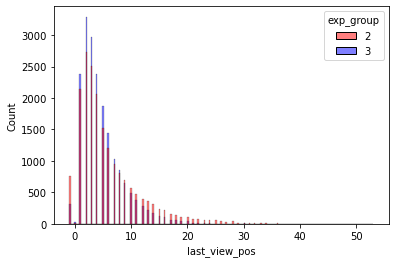

In [55]:
groups = sns.histplot(data = df, 
              x='last_view_pos', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [19]:
# Есть ли пользователи, у которых за ноябрь поменялась exp_group

q = """
    select distinct user_id
    from simulator.feed_actions
    where toDate(time) between '2021-11-01' and '2021-11-30'
"""
november_users = pandahouse.read_clickhouse(q, connection=connection)

In [20]:
november_users.count()

user_id    85575
dtype: int64

In [17]:
# Есть экспериментальные группы 2 и 3
# На этих группах с 8 по 14 ноября был АА-тест
# с 15 по 21 ноября 2021 – АБ-тест с нашими системами рекомендаций 

In [25]:
def ab_split(id, salt='exp_mess_2', n_groups=4):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [26]:
november_users['group2'] = november_users['user_id'].swifter.apply(ab_split)

Pandas Apply:   0%|          | 0/85575 [00:00<?, ?it/s]

In [27]:
november_users.groupby('group2')['user_id'].count()

group2
0    21484
1    21238
2    21473
3    21380
Name: user_id, dtype: int64

In [28]:
november_users.head()

,user_id,group,group2
0,11600,2,2
1,15488,0,2
2,17053,2,2
3,112029,0,2
4,112233,3,1


In [38]:
to_draw = df.groupby(['dt', 'exp_group'])['last_view_pos'].mean().reset_index()

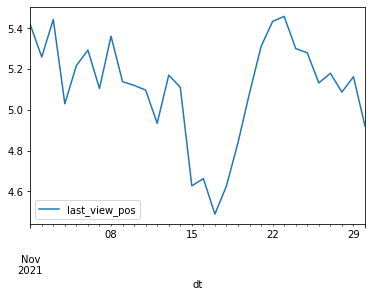

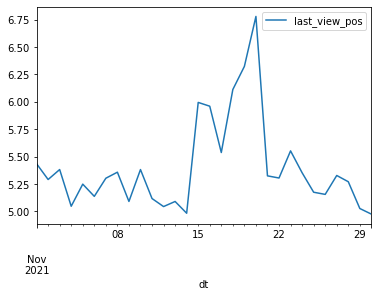

In [43]:
to_draw[to_draw.exp_group == 3].plot(x = 'dt', y = 'last_view_pos')


In [46]:
gr3_mean = to_draw[to_draw.exp_group == 3].last_view_pos.mean()

gr2_mean = to_draw[to_draw.exp_group == 2].last_view_pos.mean()

gr2_mean, gr3_mean

(5.403112554148676, 5.108603775448964)

In [58]:
df2 = df[df.exp_group == 2].last_view_pos
df3 = df[df.exp_group == 3].last_view_pos

In [60]:
stats.ttest_ind(df2, df3, equal_var = False)

Ttest_indResult(statistic=23.464834058753873, pvalue=8.908871893872433e-121)

In [61]:
df2.mean(), df3.mean()

(6.008614388639448, 4.81509648714367)